In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import zipfile



In [2]:
kaggle_dataset = "rahulsah06/gooogle-stock-price"
dataset_zip = "gooogle-stock-price.zip"
csv_file = "Google_Stock_Price_Train.csv"

# Download dataset if not already downloaded
if not os.path.exists(dataset_zip):
    print("Downloading dataset from Kaggle...")
    os.system(f"kaggle datasets download -d {kaggle_dataset}")
else:
    print("Dataset already downloaded.")

# Extract dataset if not already extracted
if not os.path.exists(csv_file):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall()
else:
    print("Dataset already extracted.")

# Load the dataset
file_path = csv_file
if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} not found. Please check the Kaggle dataset or extraction process.")
    
df = pd.read_csv(file_path)
print("Dataset loaded successfully!")
print(df.head())

# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
df = df[features]

# Remove commas and convert to numeric
df.replace(',', '', regex=True, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values
df.ffill(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
SEQ_LENGTH = 30  # Number of past days
PRED_LENGTH = 1  # Predict next day

def create_sequences(data, seq_length, pred_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        seq = data[i:i + seq_length]
        label = data[i + seq_length:i + seq_length + pred_length, -1]  # Predicting 'Close'
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_data, SEQ_LENGTH, PRED_LENGTH)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)


Dataset already downloaded.
Extracting dataset...
Dataset loaded successfully!
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


In [3]:
class StockPriceGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.2):
        super(StockPriceGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_out = gru_out[:, -1, :]  # Use the last time step
        return self.fc(last_out)


In [4]:
def train_gru_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device):
    model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Save the losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
    
    return best_model, best_val_loss, train_losses, val_losses


In [5]:
def evaluate_gru_model(model, test_loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            predictions.append(outputs.cpu().numpy())
            actuals.append(batch_y.cpu().numpy())
    predictions = np.concatenate(predictions).reshape(-1, 1)
    actuals = np.concatenate(actuals).reshape(-1, 1)
    return predictions, actuals


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = X_train.shape[2]
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 20

# Initialize the GRU model
gru_model = StockPriceGRU(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Train the model
best_gru_model, best_val_loss, train_losses, val_losses = train_gru_model(
    gru_model, train_loader, val_loader, optimizer, criterion, EPOCHS, device
)


Epoch 1/20 - Train Loss: 0.0069 - Val Loss: 0.0054
Epoch 2/20 - Train Loss: 0.0051 - Val Loss: 0.0054
Epoch 3/20 - Train Loss: 0.0049 - Val Loss: 0.0050
Epoch 4/20 - Train Loss: 0.0047 - Val Loss: 0.0048
Epoch 5/20 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 6/20 - Train Loss: 0.0046 - Val Loss: 0.0045
Epoch 7/20 - Train Loss: 0.0045 - Val Loss: 0.0044
Epoch 8/20 - Train Loss: 0.0044 - Val Loss: 0.0040
Epoch 9/20 - Train Loss: 0.0042 - Val Loss: 0.0042
Epoch 10/20 - Train Loss: 0.0041 - Val Loss: 0.0038
Epoch 11/20 - Train Loss: 0.0041 - Val Loss: 0.0037
Epoch 12/20 - Train Loss: 0.0038 - Val Loss: 0.0036
Epoch 13/20 - Train Loss: 0.0037 - Val Loss: 0.0035
Epoch 14/20 - Train Loss: 0.0036 - Val Loss: 0.0033
Epoch 15/20 - Train Loss: 0.0036 - Val Loss: 0.0034
Epoch 16/20 - Train Loss: 0.0039 - Val Loss: 0.0033
Epoch 17/20 - Train Loss: 0.0036 - Val Loss: 0.0034
Epoch 18/20 - Train Loss: 0.0037 - Val Loss: 0.0035
Epoch 19/20 - Train Loss: 0.0036 - Val Loss: 0.0032
Epoch 20/20 - Train L

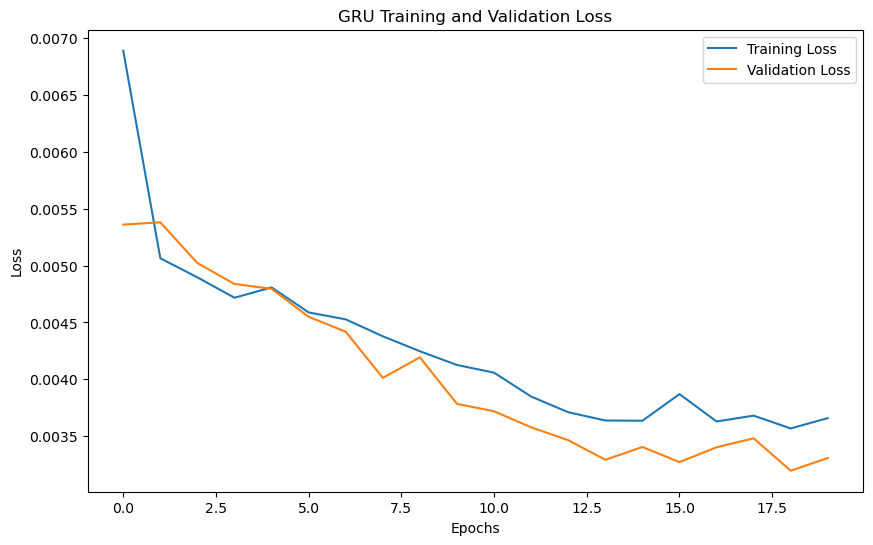

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("GRU Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [13]:
gru_model.load_state_dict(best_gru_model)
test_predictions, test_actuals = evaluate_gru_model(gru_model, test_loader, device)

# Reverse scaling
def reverse_scaling(predictions, actuals, scaler, num_features):
    predictions = scaler.inverse_transform(
        np.hstack([np.zeros((predictions.shape[0], num_features - 1)), predictions])
    )[:, -1]
    actuals = scaler.inverse_transform(
        np.hstack([np.zeros((actuals.shape[0], num_features - 1)), actuals])
    )[:, -1]
    return predictions, actuals

test_predictions, test_actuals = reverse_scaling(test_predictions, test_actuals, scaler, X.shape[2])

# Calculate metrics
test_mse = mean_squared_error(test_actuals, test_predictions)
test_mae = mean_absolute_error(test_actuals, test_predictions)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Test MSE: 2209813180587.1631
Test MAE: 897965.2564


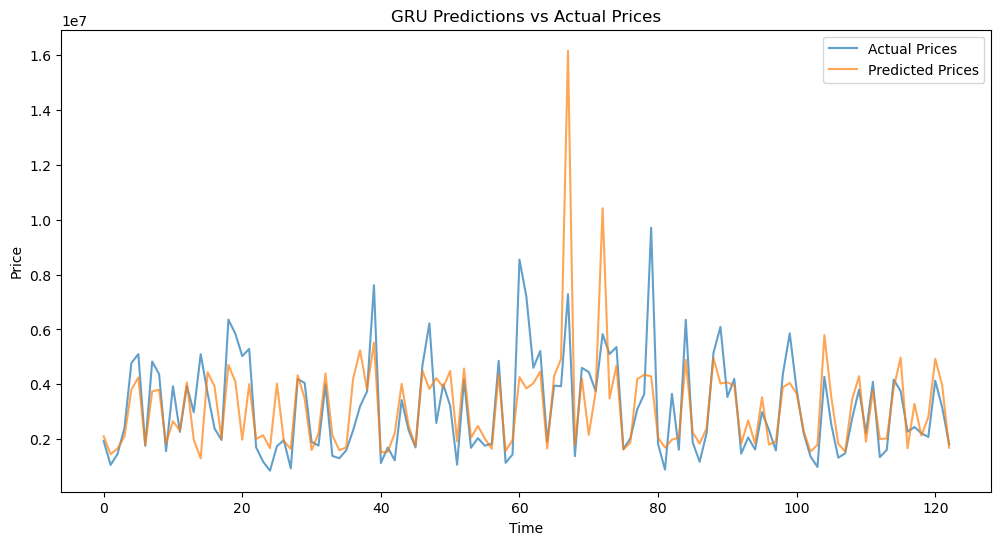

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(test_actuals, label="Actual Prices", alpha=0.7)
plt.plot(test_predictions, label="Predicted Prices", alpha=0.7)
plt.title("GRU Predictions vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
